In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading dataframes for each protein into python 
Renaming columns to be easily accessable, normalizing the excitation and emission spectra, taking sum of column 

In [3]:
df_mEmerald = pd.read_csv('mEmerald_fpbase_spectra.csv')
df_mEmerald.fillna(0, inplace = True)
df_mTagBFP2 = pd.read_csv('mTagBFP2_fpbase_spectra.csv')
df_mTagBFP2.fillna(0, inplace = True)
df_mCherry = pd.read_csv('mCherry_fpbase_spectra.csv')
df_mCherry.fillna(0, inplace = True)
df_mNeptune2p5 = pd.read_csv('mNeptune2p5_fbpase_spectra.csv')
df_mNeptune2p5.fillna(0, inplace = True)

mEmerald_columns = df_mEmerald.rename(columns ={'mEmerald ex': 'excitation', 'mEmerald em': 'emission'})
mTagBFP2_columns = df_mTagBFP2.rename(columns ={'mTagBFP2 ex': 'excitation', 'mTagBFP2 em': 'emission'})
mCherry_columns = df_mCherry.rename(columns ={'mCherry ex': 'excitation', 'mCherry em': 'emission'})
mNeptune2p5_columns = df_mNeptune2p5.rename(columns ={'mNeptune2.5 ex': 'excitation', 'mNeptune2.5 em': 'emission'})

spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]
for j in range(0,4):
    excitation_column = spectra_list[j]['excitation']
    area = np.trapz(excitation_column, dx = 1)
    normalized = excitation_column/area
    excitation_column = normalized
    spectra_list[j]['excitation'] = normalized
    new_area = np.trapz(excitation_column, dx = 1)
    column = spectra_list[j]['emission']
    area_emission = np.trapz(column, dx = 1)
    normalized_em = column/area_emission
    column = normalized_em
    spectra_list[j]['emission'] = normalized_em
    new_area_em = np.trapz(column, dx = 1)

### Making sure each spectra dataframe has data for 400-900nm

In [4]:
wavelength = 701
for index in range(401, 601):
    mEmerald_columns.loc[len(mEmerald_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 651
for index in range(341, 591):
    mTagBFP2_columns.loc[len(mTagBFP2_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

wavelength = 851
for index in range(621, 671):
    mNeptune2p5_columns.loc[len(mNeptune2p5_columns.index)] = [wavelength, 0.0, 0.0]
    wavelength = wavelength + 1

### Function to solve emission bin area using $i$ and $j$ 
Corresponding lambda_min and lambda_max to the min and max wavelengths in channel i in a list of the 200 total bins 

In [5]:
spectra_list = [mEmerald_columns, mTagBFP2_columns, mCherry_columns, mNeptune2p5_columns]

def calc_emission_bin(i, j):
    bins_list = [*range(400, 900, 10)]
    total_bins = 4*bins_list 
    df_spectra = spectra_list[j]
    lambda_min = total_bins[i]
    lambda_max = lambda_min + 10
    bin_i = range(lambda_min, lambda_max)
    df_sliced_data = df_spectra.loc[df_spectra['wavelength'].isin(bin_i)]
    # print(df_sliced_data)
    sliced_data_emmision = df_sliced_data['emission']
    emission_bin = np.trapz(sliced_data_emmision)
    # print('Emission bin sum for i = ', i, 'and j = ', j, 'is', emission_bin)
    return emission_bin

### Function to calculate the excitation values from the illumination wavelengths
Excitation value corresponding to excitation wavelengths for each protein: 405nm, 488nm, 561nm, 637nm. Found these values on csv files

In [6]:
def calc_excitation(i, j): 
    illumation_wavelength_list = [405, 488, 561, 637]
    if 0 <= i < 50: 
        illumation_wavelength = illumation_wavelength_list[0]
    elif 50 <= i < 100: 
        illumation_wavelength = illumation_wavelength_list[1]
    elif 100 <= i < 150:
        illumation_wavelength = illumation_wavelength_list[2]
    elif 150 <= i < 200:
        illumation_wavelength = illumation_wavelength_list[3]
    else:
        print('Invalid i value')
    df_sliced = spectra_list[j].loc[spectra_list[j]['wavelength'] == illumation_wavelength]
    excitation_wavelength = df_sliced['excitation'].iloc[0]
    
    return excitation_wavelength

### Function to index over brightness values using a given $j$

In [7]:
def calc_brightness(j):
    # Found brightness values on slack 
    brightness_list = [39.1, 32.38, 15.85, 22.8] 
    brightness = brightness_list[j]
    # print('Brightness value for j = ', j, 'is', brightness)
    return brightness

### Imaging model without before $k$ is specified
Using the average of matrix A (per 50 channels) from this imaging model to calculate K for the real imaging model

In [8]:
def calc_a_ij_wo_k(i, j) :
    k = 1
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a_ij = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a_ij

def form_matrix_A_wo_k():
    A = np.zeros((200, 4))
    for j in range(0, 4):
        for i in range(0, 200):
            A[i, j] = calc_a_ij_wo_k(i, j)
    return A

In [9]:
calc_a_ij_wo_k(10, 0)
# B = form_matrix_A_wo_k() 
# B[10,0]

0.017846902914808855

### Function for the variable $k_i$
We are trying to give each fluorophore a fair chance. Each of our illumination wavelengths is targetted mainly at a specific fluorophore. Experimentally, we can choose the illumination strengths. So, we want to balance out our illumination strengths so that a similar amount of information (photons) is collected from each fluorophore emissions.

Depends on the channel--each set of 50 channels will have a different $k_i$. Could make it depend on the brightnesses.

In [10]:
def calc_k_strength(i, desired_photons):
        A_constant_k = form_matrix_A_wo_k()
        illumination_one = A_constant_k[0:50, 0:4]
        illumination_two = A_constant_k[50:100, 0:4]
        illumination_three = A_constant_k[100:150, 0:4]
        illumination_four = A_constant_k[150:200, 0:4]
        if 0 <= i < 50: 
                sliced_average = np.average(illumination_one)
                k = 1/(sliced_average) * desired_photons
        elif 50 <= i < 100:
                sliced_average = np.average(illumination_two)
                k = 1/(sliced_average) *desired_photons
        elif 100 <= i < 150:
                sliced_average = np.average(illumination_three)
                k = 1/(sliced_average) * desired_photons
        elif 150 <= i < 200:
                sliced_average = np.average(illumination_four)
                k = 1/(sliced_average) * desired_photons
        return k 

In [11]:
calc_k_strength(10, 100)

30740.88858655248

### Imaging model with $k$ specified
Created a list of k values since there are only four total (reduces run time)

In [20]:
def form_k_list(desired_photons):
    k_list = []
    for i in [0, 50, 100, 150]:
        k = calc_k_strength(i, desired_photons)
        k_list.append(k)
        
    return k_list

def calc_a_ij(i, j, k_list):
    # Replaced line below because it is too computationally intensive
    # k = calc_k_strength(i, desired_photons)
    if 0 <= i < 50: 
        k = k_list[0]
    elif 50 <= i < 100:
        k = k_list[1]
    elif 100 <= i < 150:
        k = k_list[2]
    elif 150 <= i < 200:
        k = k_list[3]
    brightness_value = calc_brightness(j)
    excitation_value = calc_excitation(i, j)
    emission_bin_area = calc_emission_bin(i, j)
    a_ij = k * brightness_value * excitation_value * emission_bin_area
    # print('Matrix A for image channel i = ', i, ' and spectrum j = ', j, 'is ', a)
    return a_ij

def form_matrix_A(desired_photons):
    k_list = form_k_list(desired_photons)
    A = np.zeros((200, 4))
    for j in range(0, 4):
        for i in range(0, 200):
            A[i, j] = calc_a_ij(i, j, k_list)
    return A

### Created a list of matrices so we are now able to easily create multiple "A" matrices for varying desired photon values. 
Can choose a specific one by indexing over the list 

In [13]:
def calc_A_for_varying_photons(desired_photons_list):
    # Input: list of average detected photons desired
    # Output: list of corresponding A matrices
    matrix_A_list = []
    for desired_photons in desired_photons_list:
        A = form_matrix_A(desired_photons)
        matrix_A_list.append(A)

    return matrix_A_list

### Create a vector consisting of some concentration of each fluorophore
The concentrations don't have to all be the same. Modeling our imaging system -- using one of each fluorophore in this example. Each index corresponds to a fluorophore

In [14]:
x = [1, 1, 1, 1] ##might have to switch orientation if error (transpose)

### Function to calculate FOM from $A$ and $x$ 
1. Multiplying Matrix A by Vector x (calculating the measurements of y using imaging model)
2. Transposing A using simple command '.T'
3. Creating diagonal matrix of 1/y
4. Multiply all three matrices and compute the fisher information matrix
5. Inversing the fisher information matrix. 
6. Take out all the diagonal elements in the fisher information matrix (these are the CRLB numbers).
7. Square root all the CRLB numbers.
8. Divide the fluorophore concentrations by the square-rooted CRLB numbers (would have to change code if don't use 1 for each concentration)

If you inverse the fisher information matrix and multiply it by the initial fisher information matrix, should get a diagonal matrix of all 1's on the diagonal (and the rest of the elements should be 0. Ours are very small numbers that would round to zero).

i.e. (idk = FIM_inverse @ FIM) should result in that

In [15]:
def calc_FOM(A, x):
    y = A @ x 
    y_reshaped = np.reshape(y, (200, 1))
    transposed_A = A.T
    FIM_y = 1/y
    FIM_y[FIM_y == np.inf] = 0
    diagonal_matrix = np.diag(FIM_y)
    FIM = transposed_A @ diagonal_matrix @ A
    FIM_inverse = np.linalg.inv(FIM)
    CRLB_0 = FIM_inverse[0,0] 
    CRLB_1 = FIM_inverse[1,1]
    CRLB_2 = FIM_inverse[2,2]
    CRLB_3 = FIM_inverse[3,3]
    CRLB_list = [CRLB_0, CRLB_1, CRLB_2, CRLB_3]
    sqrt_CRLB_list = np.sqrt(CRLB_list)
    FOM_list = [1/i for i in sqrt_CRLB_list] #would have to change this line of code if don't use 1 for each concentration
    
    return FOM_list


### Forming our imaging models based on the number of detected photons

Using time function to check how long each process takes to run

In [16]:
import time

st = time.time()

k_list = form_k_list(100)
print(f"List of k values: {k_list}")
a = calc_a_ij(0, 0, k_list)
print(f"a: {a}")

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


List of k values: [30740.88858655248, 36033.13727501114, 75451.7982786767, 497698.88987024943]
a: 0.0
Execution time: 1.026256799697876 seconds


In [17]:
st = time.time()

A_list = calc_A_for_varying_photons([100, 200, 300])

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')


Execution time: 4.00855278968811 seconds


### Calculating the average number of detected photons
Checking if the number of photons matches what we would expect

In [18]:
def calc_avg_detected_photons(A):
    avg_photons_detected_list = []
    for illum_count in range(4):
        # start = 50 * illum_count
        # end = 50 * (illum_count + 1)
        # print(f"Start row: {start}, End row: {end}")
        A_section = A[50 * illum_count : 50 * (illum_count + 1), :]
        avg_photons_detected = np.average(A_section)
        avg_photons_detected_list.append(avg_photons_detected)

    return avg_photons_detected_list

In [19]:
A = form_matrix_A(200)
calc_avg_detected_photons(A)

[199.99999999999991, 200.00000000000003, 200.00000000000003, 200.0]

### Plotting the FOMs against avg # of detected photons for desired_photons = 100, 200, 300
Using $x_j$ = [1, 1, 1, 1]

Creating matrix A for detected photons 100, 200, 300.

Can do for loop to get an FOM_list, which will contain lists of length four for the FOM values. This will allow us to plot the desired_photons_list vs. FOM_list[??] for fluorophore $j$. We can make this plot for each $j$. Then, we can put the four scatter plots on the same graph.

In [22]:
desired_photons_list = [100, 200, 300]
A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list)

Calculating FOMs and avg detected photons for desired photons = 100

In [25]:
FOM_for_100 = calc_FOM(A_for_desired_photons[0], x)
print(FOM_for_100)

[142.16683348965225, 123.00199181782055, 63.91368169084966, 142.8972546377778]


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_21184/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


In [33]:
Avg_photons_100 = calc_avg_detected_photons(A_for_desired_photons[0])
print(Avg_photons_100)

[99.99999999999996, 100.00000000000001, 100.00000000000001, 100.0]


Calculating FOMs and avg detected photons for desired photons = 200

In [27]:
FOM_for_200 = calc_FOM(A_for_desired_photons[1], x)
print(FOM_for_200)

[201.05426404070377, 173.95108502766632, 90.38759546839654, 202.08723553462698]


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_21184/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


In [34]:
Avg_photons_200 = calc_avg_detected_photons(A_for_desired_photons[1])
print(Avg_photons_200)

[199.99999999999991, 200.00000000000003, 200.00000000000003, 200.0]


Calculating FOMs and avg detected photons for desired photons = 300

In [29]:
FOM_for_300 = calc_FOM(A_for_desired_photons[2], x)
print(FOM_for_300)

[246.24017875526235, 213.04569926063652, 110.70174398733622, 247.5053052947384]


/var/folders/jt/_z0pnbx50rs5xql_tz09rgq00000gn/T/ipykernel_21184/4025655968.py:5: RuntimeWarning: divide by zero encountered in true_divide
  FIM_y = 1/y


In [36]:
Avg_photons_300 = calc_avg_detected_photons(A_for_desired_photons[2])
print(Avg_photons_300)

[299.99999999999994, 300.00000000000006, 300.0, 300.0]


### Plot for each flurophore with points/FOMs for desired photons = 100, 200, and 300 on plot 

For mEmerald

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mEmerald')

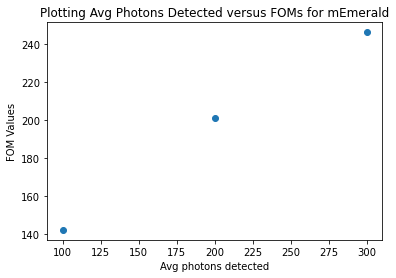

In [38]:
plt.scatter(x = [Avg_photons_100[0], Avg_photons_200[0], Avg_photons_300[0]], y = [FOM_for_100[0], FOM_for_200[0], FOM_for_300[0]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mEmerald')

For mTagBFP2

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mTagBFP2')

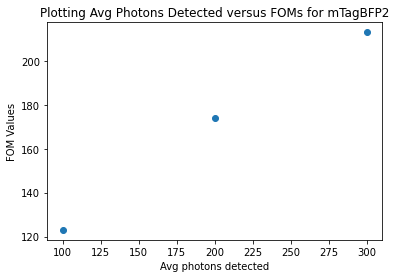

In [39]:
plt.scatter(x = [Avg_photons_100[1], Avg_photons_200[1], Avg_photons_300[1]], y = [FOM_for_100[1], FOM_for_200[1], FOM_for_300[1]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mTagBFP2')

For mCherry

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mCherry')

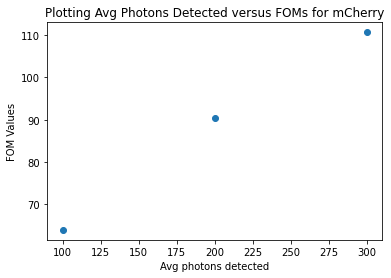

In [40]:
plt.scatter(x = [Avg_photons_100[2], Avg_photons_200[2], Avg_photons_300[2]], y = [FOM_for_100[2], FOM_for_200[2], FOM_for_300[2]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mCherry')

For mNeptune2.5

Text(0.5, 1.0, 'Plotting Avg Photons Detected versus FOMs for mNeptune2.5')

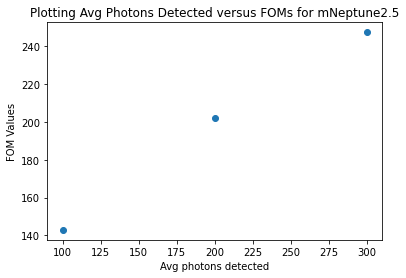

In [41]:
plt.scatter(x = [Avg_photons_100[3], Avg_photons_200[3], Avg_photons_300[3]], y = [FOM_for_100[3], FOM_for_200[3], FOM_for_300[3]])
plt.ylabel('FOM Values')
plt.xlabel('Avg photons detected')
plt.title('Plotting Avg Photons Detected versus FOMs for mNeptune2.5')

Can look into plotting the emission spectra of the fluorophores -- might display overlap/crosstalk, which lowers FOMs

Work on combining all four plots into single plot and should have about 20 desired photon values for each fluorophore (looking for a platoe on the graph which shows the optimal illumination strength). Can't know for sure because would need to take into account other factors in the imaging model (i.e. bleaching). Looking to create plot to give complete picture of how well imaging system works. Maybe make each fluorophore a certain color